In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

In [206]:
### loop over ppseq output files, save out thresholded data into new folder - in a format that can be eaily loaded for future plotting etc. 

In [177]:
mouse_session_recording.split('_')[-1]

'10'

In [178]:
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][-1] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)

['recording10_05-15-2023',
 'recording1_05-01-2023',
 'recording2_05-02-2023',
 'recording3_05-03-2023',
 'recording4_05-05-2023',
 'recording5_05-08-2023',
 'recording6_05-09-2023',
 'recording7_05-10-2023',
 'recording8_05-11-2023',
 'recording9_05-12-2023']

In [11]:
ignore_list = ['296_1_7']
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\long_awake\\"

PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\New_Awake\\"
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\temp2\\"

# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\old_data_filter_method\both\awake\\"

DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

In [16]:
os.listdir(PP_PATH)

['255_1_1_run_0606023_0148',
 '255_1_2_run_0606023_0211',
 '255_1_3_run_0606023_0201',
 '255_1_4_run_0606023_0216',
 '256_1_1_run_0606023_0204',
 '256_1_2_run_0606023_0202',
 '262_1_1_run_0606023_0118',
 '262_1_2_run_0606023_0148',
 '262_1_4_run_0606023_0152',
 '262_1_5_run_0606023_0159',
 '262_1_6_run_0606023_0135',
 '262_1_7_run_0606023_1635',
 '268_1_10_run_0606023_0235',
 '268_1_1_run_0606023_0248',
 '268_1_2_run_0606023_0340',
 '268_1_3_run_0606023_0306',
 '268_1_4_run_0606023_0233',
 '268_1_5_run_0606023_0215',
 '268_1_6_run_0606023_0218',
 '268_1_7_run_0606023_0210',
 '268_1_8_run_0606023_0217',
 '268_1_9_run_0606023_0205',
 '269_1_1_run_0606023_0430',
 '269_1_2_run_0606023_0153',
 '269_1_3_run_0606023_0211',
 '269_1_4_run_0606023_0158',
 '269_1_5_run_0606023_0207',
 '269_1_6_run_0606023_0208',
 '269_1_7_run_0606023_0216',
 '270_1_1_run_0606023_0205',
 '270_1_2_run_0606023_0212',
 '270_1_3_run_0606023_0209',
 '270_1_4_run_0606023_0219',
 '270_1_5_run_0606023_0208',
 '270_1_6_run

In [17]:
ignore_list = ['296_1_7']
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\long_awake\\"

PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\New_Awake\\"
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\awake\temp2\\"

# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\old_data_filter_method\both\awake\\"

DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"
for run_index,pp_file in enumerate(os.listdir(PP_PATH)):
    
#     if run_index >-1:
    if run_index ==9 :
        

        print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))) + '-------------------------------------------------------------------------')
        print(pp_file)

        mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
        region = PP_PATH.split('\\')[6]

        skip = False
        for item in ignore_list:
            if item == mouse_session_recording:
                skip = True

        save_path = PP_PATH + pp_file + '\\analysis_output\\'
        if not os.path.isdir(save_path):
            os.makedirs(save_path)

        ## set dat_path:
        for file_ in os.listdir(DAT_PATH):
            if mouse_session_recording.split('_')[0] in file_:
                if mouse_session_recording.split('_')[1] == file_[-1]:
                    dat_path = os.path.join(DAT_PATH,file_)
        for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
            if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
                dat_path = os.path.join(dat_path,recording)

        # set tracking path
        for file_ in os.listdir(dat_path + r"\video\tracking\\"):
            if 'task' in file_:
                if not 'clock' in file_:
                    tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
        # set video paths
        for file_ in os.listdir(dat_path + r"\video\videos\\"):
            if 'task' in file_:
                if not 'clock' in file_:
                    cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
                    for vid_file in os.listdir(cam_path):
                        if 'back' in vid_file and '.avi' in vid_file:
                            back_cam_avi_path = os.path.join(cam_path,vid_file)
                        if 'side' in vid_file and '.avi' in vid_file:
                            side_cam_avi_path = os.path.join(cam_path,vid_file)

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        ## LOAD 
        print("LOADING PPSEQ DATA")
        print('\n')
        #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
        assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

        # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
        latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

        # seq_type_log_proportions: log p of each type of sequence at each iteration
        seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

        # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
        # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
        neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")


        masking = False
        for dat_files in os.listdir(PP_PATH + pp_file):
            if 'unmasked_spikes' in dat_files:
                masking = True
                print('masking was used')

        if masking == True:
            #log_p_hist.csv: the history of the log_p of the model
            log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

            unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
        else:
            log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

            spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
            neuron_ids, spike_times= [], []
            with open(spikes_file) as f:
                for (i, line) in enumerate(f.readlines()):
                    [neuron_id, spike_time] = line.split(' ', 1)
                    spike_time = eval(spike_time.split('\n')[0])
                    neuron_id = eval(neuron_id.split('\t')[0])
                    spike_times.append(spike_time)
                    neuron_ids.append(neuron_id)
            unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

        bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")


        # Opening JSON file
        f = open(PP_PATH + pp_file + r'\config_file.json')
        # returns JSON object as a dictionary
        config = eval(json.load(f))
        print(f'      done')

        if skip == False:
            ##### load deeplabcut tracking data
            print('\n')
            print("LOADING DLC TRACKING DATA")
            back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
            back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


        ## LOAD behaviour data
        print('\n')
        print("LOADING BEHAV DATA")

        ## load in the timespan used for pppseq:
        input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
        # Opening JSON file
        f = open(input_params_path)
        # returns JSON object as 
        # a dictionary
        input_config = json.load(f)
        behav_time_interval_start = input_config['time_span'][0]
        print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")
        t_difference = np.diff(behav_time_interval_start)[0]

        ### load in data:
        for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
            if 'task' in sub_file:
                behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
        behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
        transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

        behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
        poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
        ports = behav_sync[behav_mask].Port

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

        #find max value

        # find 95% of growth value and when it crossed this
        max_ = max(log_p_hist_df.x1)
        min_ = min(log_p_hist_df.x1)
        growth = max_ - min_
        _prcntile =  max_ - (0.02 * growth)

        ## model log likley hood curve
        plt.plot(log_p_hist_df.x1)
        plt.axhline(y=_prcntile, color='r', linestyle='--')


        SaveFig('log_l_curve.png',save_path)

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

        ## macth seq id to seq type across itterations

        # Initialize an empty df to store the result
        seq_types_df = pd.DataFrame()

        # Iterate through the range
        # for iteration_ in tqdm(range(400, 500)):
        for iteration_ in tqdm(range(200, 300)):

            # Extract the relevant column from the assignment history dataframe
            assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]

            # Get the index of the -1 split markers in the latent event history dataframe
            end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
            # Extract the relevant portion of the latent event history dataframe
            latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]

            # Create a dictionary from the dataframe for faster lookups
            df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()

            # Match the sequence ID to the sequence type
            seq_type = find_corresponding(assignment_history_df_split)

            # Append the result to the df
            seq_types_df[str(iteration_+1)] = seq_type


        proportion = []
        seq_type = []
        for index in tqdm(range(len(seq_types_df))):
            row = seq_types_df.loc[index]
            seq_type += [statistics.mode(row)] 
            proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]

        # add seq type to dataframe
        unmasked_spikes_df['sequence_type'] = seq_type
        # add seq type to dataframe
        unmasked_spikes_df['seq_confidence'] = proportion

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

        ## filter for background confidence :

        thresh = max(proportion) *.75
        plt.plot(np.sort(proportion)[::-1])
        plt.axhline(y = thresh, color = 'r', linestyle = '-')

        unmasked_spikes_df['sequence_type_adjusted'] = seq_type
        unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1

        SaveFig('filtering_curve.png',save_path)

         # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    


        # 1. simple raster and tracking alignment plots

        # yellow = '#F1F1C0'
        # yellow_green = '#DCE8B3'
        # green = '#A8D4B4'
        # green_blue = '#65C1BD'
        # blue_green = '#30A5C3'
        # light_blue = '#1C79B5'
        # blue = '#264999'
        # dark_blue = '#212950'

        yellow = '#E2DC92'
        green = '#69BD9D'
        blue = '#1C79B5'
        red = '#BE575F'
        dark_blue = '#264999'
        purple = '#724F94'
        gold = '#C6963E'

        # dont edit this - my code now tries to fit and rearrage these based on most often occuring seqs 
        colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]


        ### Plot sequences - basic
        timeframe = [0,t_difference]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

        ## neuron order:

        #define neuron order
        neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=[0,2,1,4,5,3])
        # make a list of idndies for each neurons new position
        neuron_permute_loc = np.zeros(len(neuron_index))
        for i in range(len(neuron_index)):
            neuron_permute_loc[i] = int(list(neuron_index).index(i))
        neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron.values.astype(int)-1]

        ## plotting:

        fig, ax = plt.subplots(1, 1,figsize=(30, 10))

        #'#FF000000' is transparent
        # colors = ['---','brown','red','blue','purple','orange','green','#FF000000']

        # plot background in grey 
        background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
        ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)

        # plot spikes without background
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

        # for index, row in unmasked_spikes_df[mask].iterrows():
        #     ax.plot(row.timestamp,np.where(neuron_index == row.neuron-1)[0][0], 'o', c = colors[int(row.sequence_type_adjusted)])



        ### add chunk lines:

        ## work out ordering chunk sizes
        split_lists = split_list(ordered_preferred_type[neuron_index])
        lens = []
        for list_ in split_lists:
            lens += [len(list_)]
        chunks = [sum(lens[0:int(np.unique(ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(ordered_preferred_type)[-1]+1)::] 

        ## plot seq divding lines:
        for i in range(len(chunks)):
            ax.axhline(y = np.cumsum(chunks)[i], color = 'grey', linestyle = '--')


        ### to do: move background neurons to the bottom and make them black

        ### now align to behaviour
        ## first in the same ay they did - ie. make the line plot 
        #then align to deeplab cut 

        SaveFig('simple_raster.png',save_path)

         # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        if t_difference > 400:
            end_time = t_difference/2
        else:
            end_time = t_difference-1
        timeframe = [0,end_time]
        #mask
        # spikemask
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

        fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

        1 ### plot ordered ppseq spikes as above:

        # plot background in grey 
        background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
        ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
        # mask to remove background neurons from the color plot
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


        ### bin the spiking and plot number of spikes for each seq type
        seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
        seq_spikes = []
        for seq_type_ in seqs:  
            seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

        # Define the bin size (in this case, 0.2s)
        bin_size = 0.2

        seq_spike_occurance = []
        for spikes_ in seq_spikes:
            # Use the numpy.histogram function to bin the data
            hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
            seq_spike_occurance += [list(hist)]

        strt_ = int(timeframe[0]/bin_size)
        end_ = int(timeframe[1]/bin_size)

        for i in range (1,len(seq_spike_occurance)):
            ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])


        ## plot the current seq type (based on binned spiking):
        nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
        max_index= []
        max_index += [np.argmax(sublist) for sublist in nth_vectors] 

        ax2.plot(max_index[strt_:end_])

        ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[(np.array(max_index)+1)[strt_:end_]], s = 100)

        ### plot the ppseq latent:

        # mask for the timespan
        latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

        # ignore anything that is below threshold * max amplitude
        thr_ = 0
        thresh_value = max(latent_event_history_df_split.amplitude) * thr_


        amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

        c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
        ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)

        SaveFig('raster_and_seq_definitions.png',save_path)

         # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        if skip == False:
            #plot tracking psoition coloured by current dominant sequence 

            # behav_mask
            mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

            # tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

            # Find the difference between PokeIN_EphysTime and the start of the behavior interval
            interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
            # Find the offset between the first poke in time and the start of the timeframe
            tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

            # Get the first synced time for the camera in the interval 
            interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
            # Align the tracking start with the ephys by subtracting the offset
            cam_start_time = interval_cam_times - tracking_offset
            
            
            fps = 60
            if mouse_session_recording == '148_2_2':
                fps = 40

            # Calculate the number of events based on the timeframe size and bin size
            events = np.diff(timeframe)[0] /bin_size 
            # Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
            start_ts = [cam_start_time * fps ]
            # Convert the bin size to timestamps - 60fps
            bin_ts = bin_size * fps

            # Create an empty list for end times
            end_ts = []
            # Loop through the number of events
            for i in range(int(events)):
                # If it is not the first event, set the start time as the end time of the previous event
                if i > 0:
                    start_ts += [end_ts[i-1]]
                # Add the current start time plus the bin size to the list of end times
                end_ts += [start_ts[i] + bin_ts] 



            nrow = 1 
            ncol = 1
            fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

            for ind, ax in enumerate(fig.axes):
                for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
                    ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
                for i in range(int(events)):
                    ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)


                min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
                max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
                min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
                max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
                ax.set_xlim(min_x,max_x)
                ax.set_ylim(min_y,max_y)

                ax.invert_yaxis()

            ax.set_title('timeframe = ' + str(timeframe))

            SaveFig('tracking_dominant_seq.png',save_path)

             # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

           # plot same again but instead of current dominant sequence, plot all occurances (over a threshold number of spikes)

            # this code uses the camera rame alignment stuff from the previous cell

            nrow = 6 
            ncol = 1
            fig, axs = plt.subplots(nrow, ncol,figsize=(10, 30))

            for ind, ax in enumerate(fig.axes):

                spike_number_threshold = 15
                ## find inds that break threshold 
                threshold_break_inds = np.where(seq_spike_occurance[ind+1][strt_:end_] > np.array(spike_number_threshold))[0]

                ## use this to find camera times that correspond 
                individual_seq_cam_start_ts = np.array(start_ts)[threshold_break_inds]
                individual_seq_cam_end_ts = np.array(end_ts)[threshold_break_inds]


                for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
                    ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 70)
                for i in range(int(len(individual_seq_cam_start_ts))):
                    ax.plot(back_head_centre['interped_x'].values[int(individual_seq_cam_start_ts[i])-1:int(individual_seq_cam_end_ts[i])+1],back_head_centre['interped_y'].values[int(individual_seq_cam_start_ts[i])-1:int(individual_seq_cam_end_ts[i])+1],'-',color = colors[ind+1], alpha = 1)


                min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
                max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
                min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
                max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
                ax.set_xlim(min_x,max_x)
                ax.set_ylim(min_y,max_y)

                ax.invert_yaxis()

            ax.set_title('timeframe = ' + str(timeframe))

            SaveFig('tracking_all_seq_spikes_locations.png',save_path)


        ## save out data:
        unmasked_spikes_df.to_pickle(save_path +  "spikes_seq_type_adjusted.pickle")
        np.save(save_path+ 'neuron_order.npy', neuron_order)
        np.save(save_path+ 'neuron_permute_loc.npy', neuron_permute_loc)
        np.save(save_path+ 'ordered_preferred_type.npy', ordered_preferred_type)
        np.save(save_path+ 'neuron_index.npy', neuron_index)
        
        latent_event_history_df_split.to_pickle(save_path +  "latent_event_history_df_split.pickle")


10/45-------------------------------------------------------------------------
178_1_7_run_2701023_1720
LOADING PPSEQ DATA


masking was used
      done


LOADING DLC TRACKING DATA
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
['head_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [

100%|████████████████████████████████████████████████████████████████████████| 159426/159426 [00:36<00:00, 4311.06it/s]
<ipython-input-17-b87ad4bd3a35>:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1


# 2. reorder, recolor and save these plots out


In [96]:
new_dark_blue = '#36495E'
new_cyan = '#64BFB5'
new_green = '#8FC681'
new_yellow = '#FFD161'
new_orange = '#ED6F5D'
new_grey = '#ABB9B2'

red = new_dark_blue
green = new_cyan
yellow = new_green
blue = new_yellow
purple = new_orange
gold = new_grey

# recolor and save these plots out

current_color_order = [purple, blue, red, gold, yellow, green]

colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]
# ## recolor based on current and desired color order

new_order_inds = [0]
for item in current_color_order:
    new_order_inds += [np.where(np.array(colors) == item)[0][0]]

# apply this ordering
new_colors = colors.copy()
for i,index in enumerate(new_order_inds):
    colors[index] = new_colors[i]                     
                       
# determine new ordering based on this as well
ordering = list((np.array(new_order_inds)-1)[np.array(new_order_inds)-1 >=0])
#swap last 'extra' seq down to the bottom 
ordering = [ordering[-1]] + ordering[0:-1]

print(ordering)



########### IF ORDERING DOESNT WORK DO IT MANUALLY: ######

ordering = [4, 3, 0, 5, 2,1]

[1, 4, 3, 0, 5, 2]


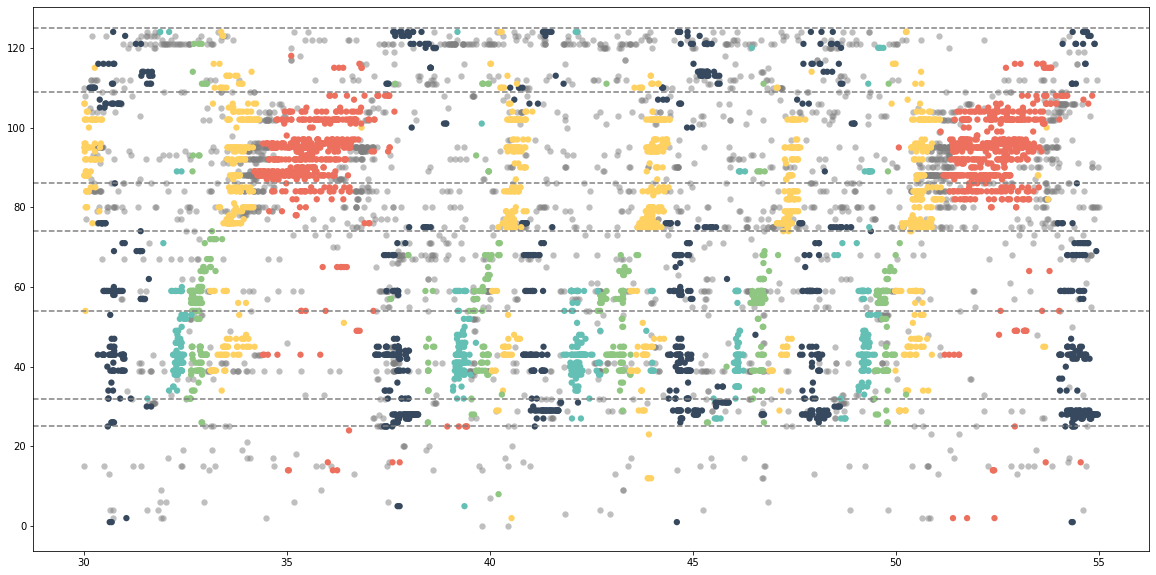

In [97]:
### Plot sequences - basic
timeframe = [30,55]
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

## neuron order:

#define neuron order
neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
# make a list of idndies for each neurons new position
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron.values.astype(int)-1]

## plotting:

fig, ax = plt.subplots(1, 1,figsize=(20, 10))

#'#FF000000' is transparent
# colors = ['---','brown','red','blue','purple','orange','green','#FF000000']
    
# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

# for index, row in unmasked_spikes_df[mask].iterrows():
#     ax.plot(row.timestamp,np.where(neuron_index == row.neuron-1)[0][0], 'o', c = colors[int(row.sequence_type_adjusted)])



### add chunk lines:

## work out ordering chunk sizes
split_lists = split_list(ordered_preferred_type[neuron_index])
lens = []
for list_ in split_lists:
    lens += [len(list_)]
chunks = [sum(lens[0:int(np.unique(ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(ordered_preferred_type)[-1]+1)::] 

## plot seq divding lines:
for i in range(len(chunks)):
    ax.axhline(y = np.cumsum(chunks)[i], color = 'grey', linestyle = '--')


### to do: move background neurons to the bottom and make them black

### now align to behaviour
## first in the same ay they did - ie. make the line plot 
#then align to deeplab cut 

In [98]:
import random

def shuffle(aList):
    random.shuffle(aList)
    return aList

### Plot sequences - basic
timeframe = [218,248]
timeframe = [235,248]

mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

## neuron order:

#define neuron order
neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
# make a list of idndies for each neurons new position
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
    

neuron_permute_loc = np.array(shuffle(list(neuron_permute_loc.astype(int))))
# neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron-1]
neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron.values.astype(int)-1]

## plotting:
nrow = 3 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(13, 16))

for ind, ax in enumerate(fig.axes):
    
    if ind == 0:
        # plot background in grey 
        background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
        ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)

        # plot spikes without background
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)
        
    if ind == 1:
        
        #define neuron order
        neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
        # make a list of idndies for each neurons new position
        neuron_permute_loc = np.zeros(len(neuron_index))
        for i in range(len(neuron_index)):
            neuron_permute_loc[i] = int(list(neuron_index).index(i))
#         neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron-1]
        neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron.values.astype(int)-1]

        # plot background in grey 
        background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
        ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.5)

        # plot spikes without background
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)
        
    if ind == 2:
        
        # plot background in grey 
        background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
        ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.3)

        # plot spikes without background
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)


    
    
SaveFig('unordered_ordered_colorised.pdf',save_path)


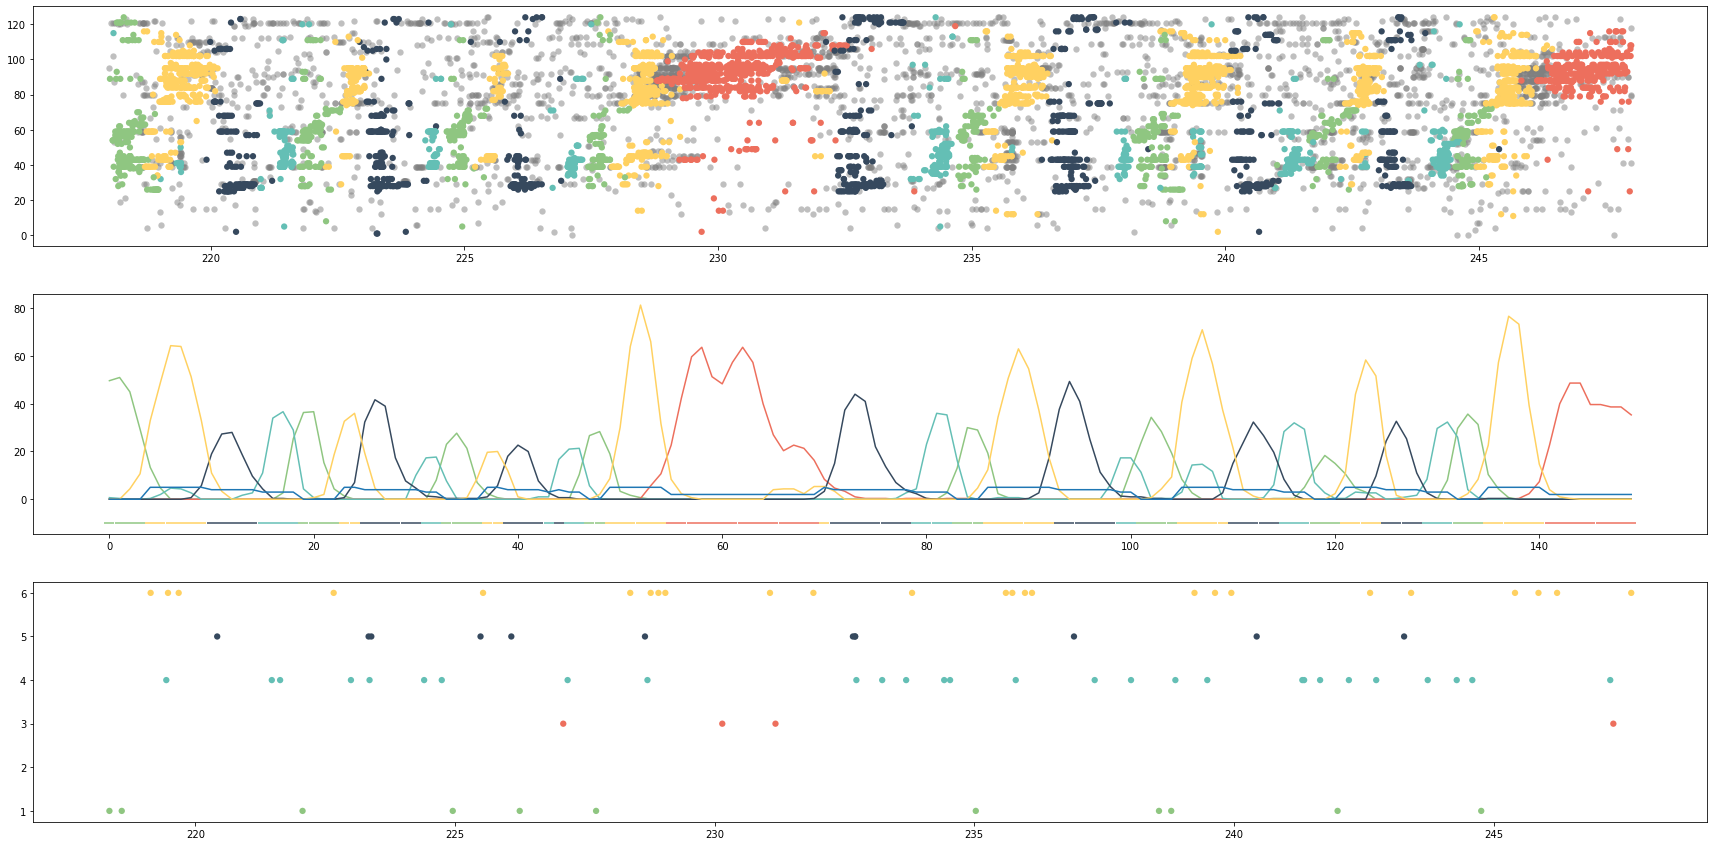

In [99]:
timeframe = [218,248]

#mask
# spikemask
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])
    

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


# SaveFig('seq_identities.png',save_path)

Text(0.5, 1.0, 'timeframe = [218, 248]')

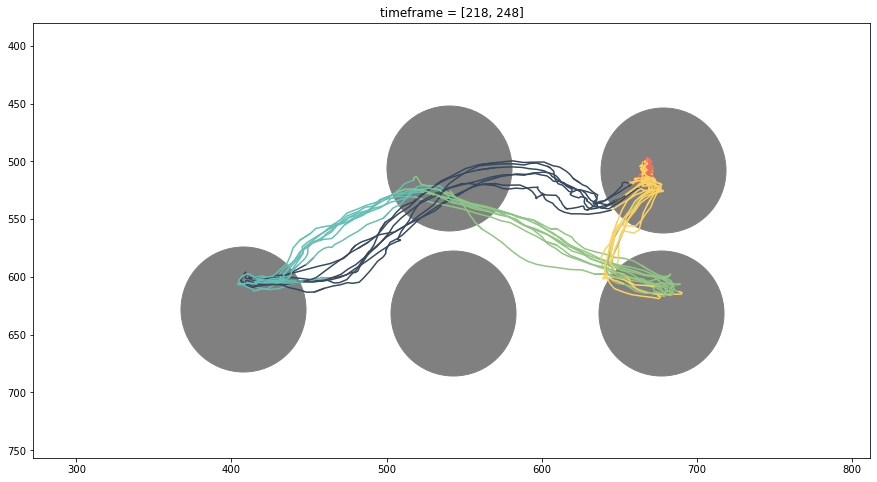

In [100]:
# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * 60 ]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * 60

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 

    
    
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)

        
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()
    
ax.set_title('timeframe = ' + str(timeframe))
    


# SaveFig('example_tracking_seq_identities_2.pdf',save_path)

In [101]:
############################# SAVE #########################################

## save out colours and order! 

### save out ordering and colors 

import pickle

filename = 'colors'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(colors, fp)

filename = 'ordering'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(ordering, fp)
    
filename = 'neuron_index'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(neuron_index, fp)
    
filename = 'ordered_preferred_type'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(ordered_preferred_type, fp)
    
    

#  3. Plot dominant seq transition histogram for each motif

Text(0.5, 117.6, 'Start motif')

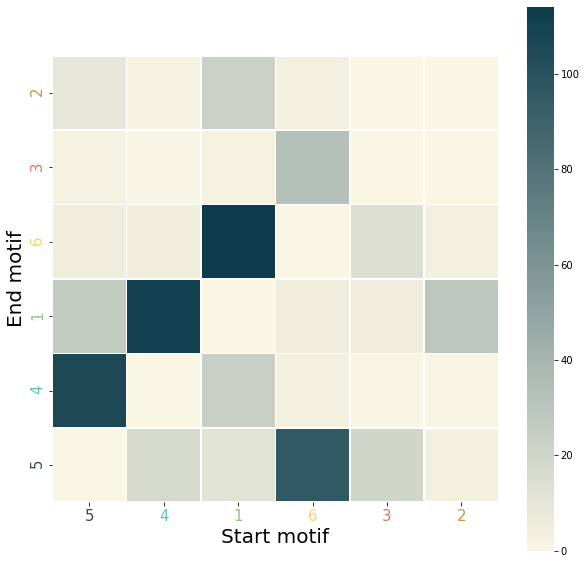

In [73]:
import seaborn as sns; 

def remove_neighboring_duplicates(nums):
    new_list = []
    for i in range(len(nums)):
        if i == 0 or nums[i] != nums[i-1]:
            new_list.append(nums[i])
    return new_list

def create_pairs(nums):
    return [nums[i]*10+nums[i+1] for i in range(len(nums)-1)]

def determineTransitionNumber(TimeFiltered_seqs,possible_transitions):
    TransitionTypesIndex = possible_transitions
    trajects = []
    for ind, transits in enumerate(TimeFiltered_seqs):
        trajects = np.append(trajects,transits)
    transition_number = []
    for transit_types in TransitionTypesIndex:
        temp = (np.where(trajects == float(transit_types)))
        transition_number.append(len(temp[0]))
    return transition_number


from matplotlib.colors import LinearSegmentedColormap

# Define the hex codes for the colors
color1 = '#F9F6E4'
color2 = '#0C3C4C'

# Create a custom colormap with two colors
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', [color1, color2], N=256)


# remove repeats
clean_seqs = remove_neighboring_duplicates(max_index)
# clean_seqs= max_index

possible_transitions = [list((np.unique(clean_seqs)+1)+10)]
for i in range(len(np.unique(clean_seqs))):
    if i > 0:
        possible_transitions += [list(np.array(possible_transitions[i-1]) + 10)]
possible_transitions = [item for sublist in possible_transitions for item in sublist]


# add one to these because dealing with 0-num transitions is difficult and then turn them into 'transition' pairs 
transit_pairs = create_pairs(np.array(clean_seqs)+1)

transition_number = determineTransitionNumber(transit_pairs,possible_transitions)

transitions_shaped = np.reshape(transition_number,(6,6))

# Reorder the array base don ordering defined earlier 
reordered_array = transitions_shaped[ordering]
reordered_array = reordered_array[:,ordering]
reordered_array = reordered_array.T[::-1]


order_strings = [str(num) for num in list(np.array(ordering) +1)]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
h1 = sns.heatmap(reordered_array, linewidths=.5,xticklabels= order_strings, yticklabels=order_strings[::-1], square=True,cmap=custom_cmap,fmt = '',cbar_kws = dict(use_gridspec=False,location="right"))

# color labels by motif/seq colour
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    tick_label.set_color(colors[ordering[::-1][i]+1])
    tick_label.set_fontsize("15")
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    tick_label.set_color(colors[ordering[i]+1])
    tick_label.set_fontsize("15")
    
    
ax.set_ylabel('End motif',size = 20)
ax.set_xlabel('Start motif',size = 20)

# SaveFig('heatmap.pdf',save_path)

#  4. Average task space for perfect seqs (defined by position) analysis  

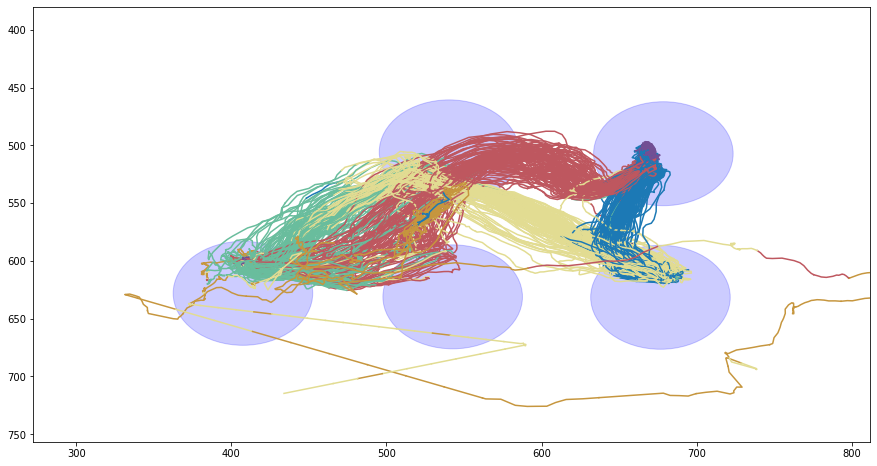

In [148]:
# behav_mask for the whole analysed time:
mask_ = (poke_in_times > 0) * (poke_in_times < np.diff(behav_time_interval_start)[0])
# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times[0] - tracking_offset
cam_end_time = cam_start_time + np.diff(behav_time_interval_start)[0]

cam_start_ts = cam_start_time * 60
cam_end_ts = cam_end_time * 60

## work out colors:

full_timeframe = [0,np.diff(behav_time_interval_start)[0]]
# Calculate the number of events based on the timeframe size and bin size
events = np.diff(full_timeframe)[0] /bin_size 
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * 60


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]
    
seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]



## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

frame_colors= []
bin_colors = np.array(colors)[np.array(max_index)+1]
for bin_color in bin_colors:
    frame_colors += [bin_color] * int(bin_ts)
    
    
# Loop through the number of events to split this up for plotting:
seg_start_ts = [cam_start_ts] 
seg_end_ts= []
for i in range(len(bin_colors)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        seg_start_ts += [seg_end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    if i == len(bin_colors)-1:
        seg_end_ts += [cam_end_ts] 
    else:
        seg_end_ts += [seg_start_ts[i] + bin_ts] 
        

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    port_centroids = []
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ## define rings around important ports: port 5, port2, port 3, port4
        port_centroid = np.median(item['interped_x'].values),np.median(item['interped_y'].values)
        radius = 45
        circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
        ax.add_patch(circle1)
        port_centroids += [port_centroid]
#         ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)


    ## plot binned segments individually
    for i in range(len(bin_colors)):
        x = back_head_centre['interped_x'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
        y = back_head_centre['interped_y'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
        ax.plot(x,y,'-',color = bin_colors[i], alpha = 1)



    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()

    #save out this data for later plotting and alanylis 
    # trim it down - it doesnt match because we add extra an extra time bin onto the end so that we know what the final left over frames should be coloree
    total_frames = len(back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)])
    
    all_frame_colors = frame_colors[0:total_frames]
    all_x_position = back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)]
    all_y_position = back_head_centre['interped_y'].values[int(cam_start_ts)-1:int(cam_end_ts)]
    
        
        

In [149]:

## find times it comes within ble circles (distance is less than radius)
## find times it does so in the order 5,2,3,4,5 with less than 2s between 

def closest_points(target, points, threshold):
    import math
    closest = []
    indicies = []
    for index,point in enumerate(points):
        distance = math.dist(target,point)
        if distance <= threshold:
            closest.append(point)
            indicies.append(index)
    return closest,indicies

def find_next_val(index,threshold_breaks,frame_filter,port_type):
    p2_indicies = np.where(threshold_breaks == port_type)[0]
    try:
        p2_min_val = min(i for i in p2_indicies if i > index)
        distance = p2_min_val - index
    except:
        distance = 9999999
    if distance<frame_filter:
        return p2_min_val
    else:
        return -1

    
coords = []
for ind_,item in enumerate(all_x_position):
    coords += [[item,all_y_position[ind_]]]
    
threshold_breaks = np.zeros(len(coords))
# for each port we care about find where the mouse breaks the distcance threshold
for ind_ in range(1,len(port_centroids)):
    threshold = radius
    target = port_centroids[ind_]
    closest,indicies = closest_points(target, coords, threshold)
    threshold_breaks[indicies] = ind_ + 1

## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
time_filter = 3 #in s
frame_filter = int(time_filter / (1/60))


# #find times when the mouse does the sequence:

start_ind = []
end_ind = []
P5_in_ind = []
index = 0
while index < len(threshold_breaks[:-1]):
# for index,break_ in enumerate(threshold_breaks[:-1]):
    break_ = threshold_breaks[index]
    if break_ == 5 and not threshold_breaks[index+1] ==5:
        # find min valin this that is larger than current - ie. next index
        p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
        if p2_ind != -1:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
            if p3_ind != -1:
                # find min valin this that is larger than current - ie. next index
                p4_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,4)
                if p4_ind != -1:
                    # find min valin this that is larger than current - ie. next index
                    p5_ind = find_next_val(p4_ind,threshold_breaks,frame_filter,5)
                    if p5_ind != -1:
                        p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
                        if p5_out_ind != -1:
                            start_ind += [index]
                            end_ind += [p5_out_ind]
                            index = p5_out_ind - 1
                        else: 
                            index +=1
                    else: 
                        index += 1
                else: 
                    index += 1
            else: 
                index += 1
        else: 
            index += 1
    else: 
        index += 1

                            
                            
# # ### for times the mouse dopesnt go near port 4
            

# start_ind = []
# end_ind = []
# P5_in_ind = []
# index = 0
# while index < len(threshold_breaks[:-1]):
# # for index,break_ in enumerate(threshold_breaks[:-1]):
#     break_ = threshold_breaks[index]
#     if break_ == 5 and not threshold_breaks[index+1] ==5:
#         # find min valin this that is larger than current - ie. next index
#         p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
#         if p2_ind != -1:
#             # find min valin this that is larger than current - ie. next index
#             p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
#             if p3_ind != -1:
#                 # find min valin this that is larger than current - ie. next index
#                 p5_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,5)
#                 # check whether once it breaks out of the port 3 radius it reenters this or enters port 4 before it goes into port 5 
#                 next_p3_break = find_next_val(p3_ind,threshold_breaks,frame_filter,0)
#                 n_p3_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,3)
#                 n_p4_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,4)
#                 if n_p3_ind == -1 or p5_ind <n_p3_ind: 
#                     if n_p4_ind == -1 or p5_ind <n_p4_ind:
#                         if p5_ind != -1:
#                             p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
#                             if p5_out_ind != -1:
#                                 start_ind += [index]
#                                 end_ind += [p5_out_ind]
#                                 index = p5_out_ind - 1
#                             else: 
#                                 index +=1
#                         else: 
#                             index += 1
#                     else: 
#                         index += 1
#                 else: 
#                     index += 1
#             else: 
#                 index += 1
#         else: 
#             index += 1
#     else: 
#         index += 1



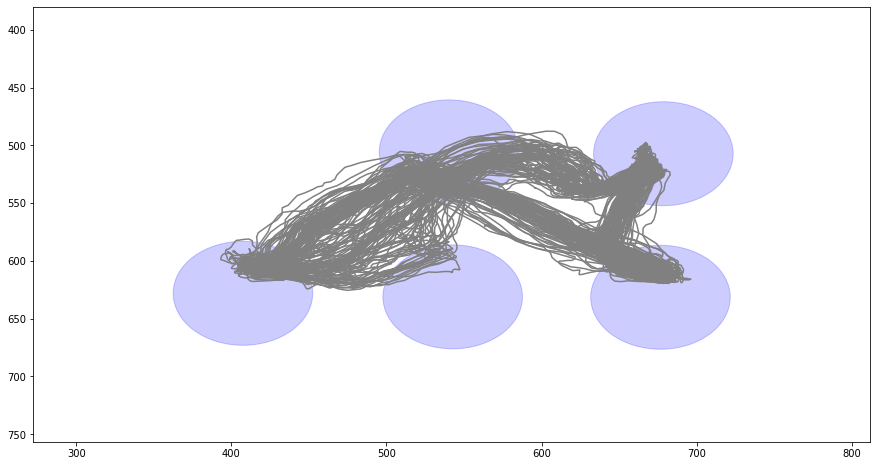

In [150]:
filtered_split_trajectories_x_positions = []
filtered_split_trajectories_y_positions = []
filtered_split_trajectories_frame_colors = []

# plot these filtered trajectories:

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    
    for port_centroid in port_centroids:
        ## define rings around important ports: port 5, port2, port 3, port4
        radius = 45
        circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
        ax.add_patch(circle1)
    
for i in range(len(start_ind)):

    
    ax.plot(all_x_position[start_ind[i]:end_ind[i]],all_y_position[start_ind[i]:end_ind[i]],'-', color = 'grey', alpha = 1)

    filtered_split_trajectories_x_positions += [all_x_position[start_ind[i]:end_ind[i]]]
    filtered_split_trajectories_y_positions += [all_y_position[start_ind[i]:end_ind[i]]]
    filtered_split_trajectories_frame_colors += [all_frame_colors[start_ind[i]:end_ind[i]]]
    
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    
    ax.invert_yaxis()

In [151]:
def find_closest_point(target, points):
    import math
    min_distance = float('inf')
    closest_point = None
    closest_index = None
    for index, point in enumerate(points):
        distance = math.dist(target,point)
        if distance < min_distance:
            min_distance = distance
            closest_point = point
            closest_index = index
    return closest_point,closest_index

def find_closest_points(traject_coords,port_centroids):
    
    split_trajects_port_points = []
    split_trajects_port_indicies = []

    closest_points = []
    closest_inds = []
    for ind_,centroids in enumerate(port_centroids[1::]):
        # skip 0 ^see above and skip port 3: 
        if not centroids == port_centroids[2]:
            if not centroids == port_centroids[-1]:
                if ind_ ==  0:
                    # find closest to port 2
                    closest_point, closest_index = find_closest_point(centroids,traject_coords)
                    closest_points += [closest_point]
                    closest_inds += [closest_index]
                else:
                    #find closest to port 4 (from after port 2 onwards)
                    closest_point, closest_index = find_closest_point(centroids,traject_coords[closest_inds[-1]::])
                    closest_points += [closest_point]
                    closest_inds += [closest_index + closest_inds[-1]]
            else:
                # if port 5 search from port 4 onwards
                closest_point, closest_index = find_closest_point(centroids,traject_coords[closest_inds[-1]::])
                closest_points += [closest_point]
                closest_inds += [closest_index + closest_inds[-1]]

    ###make it so that point closest to port 1 can only be between port 5 and 2! 
    closest_point_1, closest_index_1 = find_closest_point(port_centroids[0],traject_coords[0:closest_inds[0]])

    ###make it so that point closest to port 3 can only be between port 2 and 4! 
    closest_point_3, closest_index_3 = find_closest_point(port_centroids[2],traject_coords[closest_inds[0]:closest_inds[1]])
    # this finds relative ind so I need to add on the offst from the start of the full traject
    closest_index_3 = closest_index_3 + closest_inds[0]

    split_trajects_port_points += [[closest_point_1] + [closest_points[0]] + [closest_point_3] + closest_points[1::]]
    split_trajects_port_indicies += [[closest_index_1] + [closest_inds[0]] + [closest_index_3] + closest_inds[1::]]
    
    return split_trajects_port_points, split_trajects_port_indicies


############################################## find points in each trajectory that are closest to the end port 

split_trajects_port_points = []
split_trajects_port_indicies = []
combined_xy_trajectories = []

for i in range(len(filtered_split_trajectories_x_positions)):
    traject_coords = []
    for ind_,item in enumerate(filtered_split_trajectories_x_positions[i]):
        traject_coords += [[item,filtered_split_trajectories_y_positions[i][ind_]]]

    split_trajects_port_points_,split_trajects_port_indicies_ = find_closest_points(traject_coords,port_centroids)
    
    split_trajects_port_points += split_trajects_port_points_
    split_trajects_port_indicies += split_trajects_port_indicies_
    combined_xy_trajectories += [traject_coords]


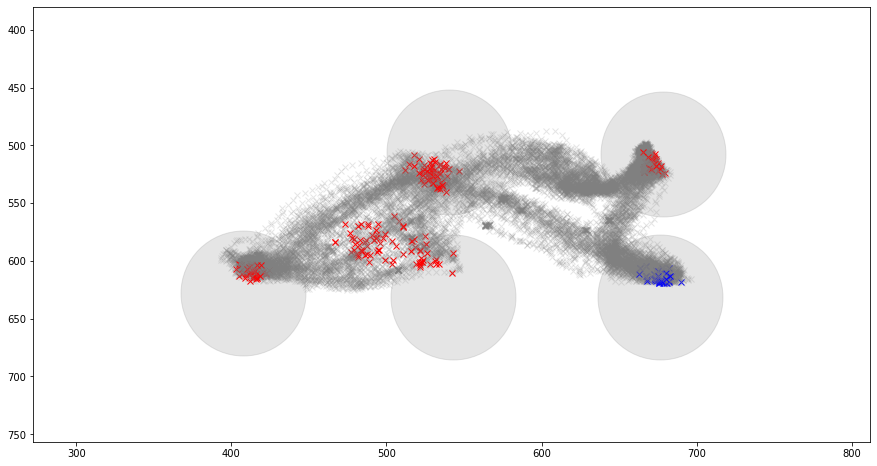

In [152]:
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()
    
    for i_ in range(len(filtered_split_trajectories_x_positions)):
        for i in range(len(filtered_split_trajectories_x_positions[i_])):
            if i in split_trajects_port_indicies[i_]:
                _colors_ = 'red'
                alpha_ = 1
                if i == split_trajects_port_indicies[i_][-2]:
                    _colors_ = 'blue'
            else:
                _colors_ = 'grey'
                alpha_ = 0.2
            ax.plot(filtered_split_trajectories_x_positions[i_][i],filtered_split_trajectories_y_positions[i_][i],'x', color = _colors_, alpha = alpha_ )
            


SaveFig('end_points.png',save_path)

In [153]:
segments_1 = []
segments_2 = []
segments_3 = []
segments_4 = []
segments_5 = []
for ind,traject_ in enumerate(combined_xy_trajectories):
    segments_1 += [traject_[0:split_trajects_port_indicies[ind][0]]]
    segments_2 += [traject_[split_trajects_port_indicies[ind][0]:split_trajects_port_indicies[ind][1]]]
    segments_3 += [traject_[split_trajects_port_indicies[ind][1]:split_trajects_port_indicies[ind][2]]]
    segments_4 += [traject_[split_trajects_port_indicies[ind][2]:split_trajects_port_indicies[ind][3]]]
    segments_5 += [traject_[split_trajects_port_indicies[ind][3]:split_trajects_port_indicies[ind][4]]]

segments = [segments_1] + [segments_2] + [segments_3] + [segments_4] + [segments_5]

In [154]:
curves=segments[-1]
# Find the length of the longest curve
max_length = max([len(curve) for curve in curves])

# Interpolate each curve to the length of the longest curve
interpolated_curves = []
for curve in curves:
    if len(curve) > 0:
        x = [point[0] for point in curve]
        y = [point[1] for point in curve]

        # find lots of points on the piecewise linear curve defined by x and y
        M = max_length
        t = np.linspace(0, len(x), M)
        x_interp = np.interp(t, np.arange(len(x)), x)
        y_interp = np.interp(t, np.arange(len(y)), y)

        interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

# # Average the x and y coordinates of all the interpolated curves
average_curve = []
for i in range(max_length):
    x_sum = 0
    y_sum = 0
    for curve in interpolated_curves:
        x_sum += curve[i][0]
        y_sum += curve[i][1]
    average_curve.append([x_sum / len(curves), y_sum / len(curves)])


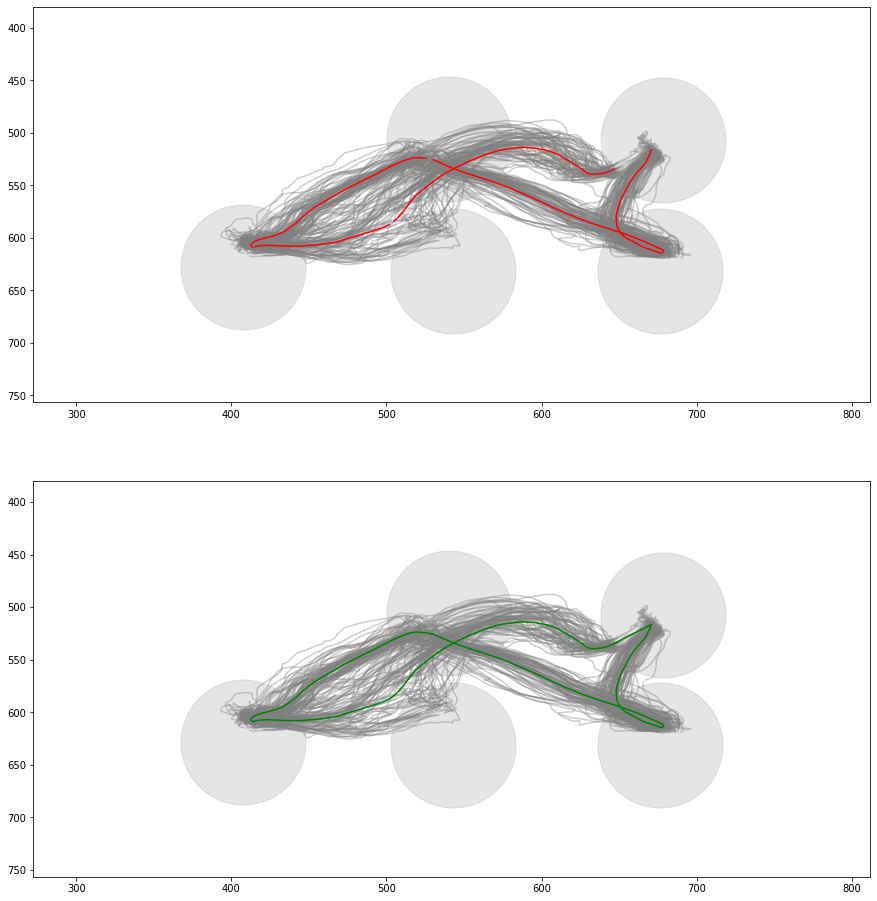

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def interpolate_to_longest_and_find_average_curve(curves):
    
    

    # Find the length of the longest curve
    max_length = max([len(curve) for curve in curves])

    # Interpolate each curve to the length of the longest curve
    interpolated_curves = []
    for curve in curves:
        if len(curve) > 0:
            x = [point[0] for point in curve]
            y = [point[1] for point in curve]

            # find lots of points on the piecewise linear curve defined by x and y
            M = max_length
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)

            interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(interpolated_curves), y_sum / len(interpolated_curves)])

    return average_curve

a_curves= []
for segment in segments:
    a_curves += [interpolate_to_longest_and_find_average_curve(segment)]


# Plot the resulting average curve
nrow = 2 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 16))

for ind, ax in enumerate(fig.axes):

    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()

    for segment in segments:
        for seg_traject in segment:
            x = [point[0] for point in seg_traject]
            y = [point[1] for point in seg_traject]
            ax.plot(x, y, '-', color ='grey',alpha = 0.4)
            
    if ind == 0:
        for a_curve in a_curves:
            x = [point[0] for point in a_curve]
            y = [point[1] for point in a_curve]
            ax.plot(x, y, color = 'red')
    else:
        a_curve_ = []
        for a_curve in a_curves:
            a_curve_ += a_curve
        # add the start back onto the end so that it is a complete loop
        a_curve_ += [a_curve_[0]]

        x = [point[0] for point in a_curve_]
        y = [point[1] for point in a_curve_]
        ax.plot(x, y, '-',color = 'green')


SaveFig('av_trajectory_trace.png',save_path)

100%|█████████████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 14776.22it/s]


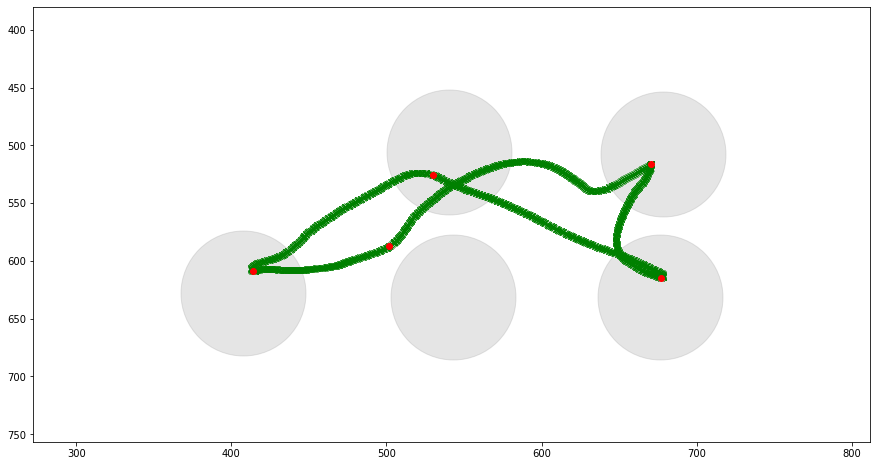

In [156]:
import numpy as np
from tqdm import tqdm
import math

def total_length_of_curve(curve):
    x = [point[0] for point in curve]
    y = [point[1] for point in curve]
    dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    return np.sum(dists)


total_length = total_length_of_curve(a_curve_)
# chose number of points you want to construct the curve out of - this will only be roughly fitted as the code does a lot of rounding. This cant be smaller than the current length - ifyou do this is will just keep the curve the same (it can only add points)
num_points = 2000
# number to multiply the segment length to get the rough breakdown so that we get around 1000 in total 
segment_warp_factor = num_points/int(total_length) 


interpolated_av_curve = []
for i in tqdm(range(len(a_curve_))):
    if i>0:
        st_ = a_curve_[i]
        ed_ = a_curve_[i-1]
        seg_distance = math.dist(st_,ed_)
        num_points_to_add = np.round(seg_distance * segment_warp_factor)
        if num_points_to_add >1:
            
            seg = [st_] + [ed_]
            x = [point[0] for point in seg]
            y = [point[1] for point in seg]
            
            M = int(num_points_to_add)
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)
            
            interpolated_av_curve += ([[x, y] for x, y in zip(x_interp, y_interp)])

            
        else:
            interpolated_av_curve += [a_curve_[i]]
            
            
# find points that are closest to eahc port:
av_curve_closestport_points,av_curve_closestport_indicies = find_closest_points(interpolated_av_curve,port_centroids)
            
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()

    x = [point[0] for point in interpolated_av_curve]
    y = [point[1] for point in interpolated_av_curve]
    ax.plot(x, y, 'x',color = 'green')
    
    for index in av_curve_closestport_indicies[0]:
        ax.plot(interpolated_av_curve[index][0],interpolated_av_curve[index][1],'o', color = 'red', alpha = 1 )

        
        

In [157]:
from scipy.spatial import KDTree

def closest_point(line1, line2):
    tree = KDTree(line2)
    dist, index = tree.query(line1)
    return index, dist

# work out rolling closest point to av line
closest_indicies = []

# extra piece is added onto the end to try and stop the end bin getting lumped with all of the leftover data  
extra_piece =50

for i in range(len(combined_xy_trajectories)):
    
    # crappy filter added in here to get around weird bug that sometimes occurs
    if split_trajects_port_indicies[i][-1] == split_trajects_port_indicies[i][-2]:
        print('bug')
        split_trajects_port_indicies[i][-2] = split_trajects_port_indicies[i][-1] - 2
    
    #find closest point from start to port to port 2
    traject = combined_xy_trajectories[i][0:split_trajects_port_indicies[i][1]]
    end_segment = av_curve_closestport_indicies[0][1]
    index, dist = closest_point(traject, interpolated_av_curve[0:end_segment+extra_piece])
    closest_inds = list(index)

    #find closest point from port 2 to port 4
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][1]:split_trajects_port_indicies[i][3]]
    start_segment = av_curve_closestport_indicies[0][1]
    end_segment = av_curve_closestport_indicies[0][3]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece:end_segment])
    #indicies are calcuated reltive to segment so add on previous segment inds
    closest_inds += list(index+av_curve_closestport_indicies[0][1])
    
    #find closest point from port 4 to port 5
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][3]:split_trajects_port_indicies[i][4]]
    start_segment = av_curve_closestport_indicies[0][3]
    end_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-10:end_segment+extra_piece])
    closest_inds += list(index+av_curve_closestport_indicies[0][3])

    #find closest point from port 5 to the rest
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][4]::]
    start_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece::])
    closest_inds += list(index+av_curve_closestport_indicies[0][4])


    closest_indicies += [closest_inds]

#### need to do this as a sort of slidnig window that I look for the closest - otherwise I get peaks that form at my end points 
    
    


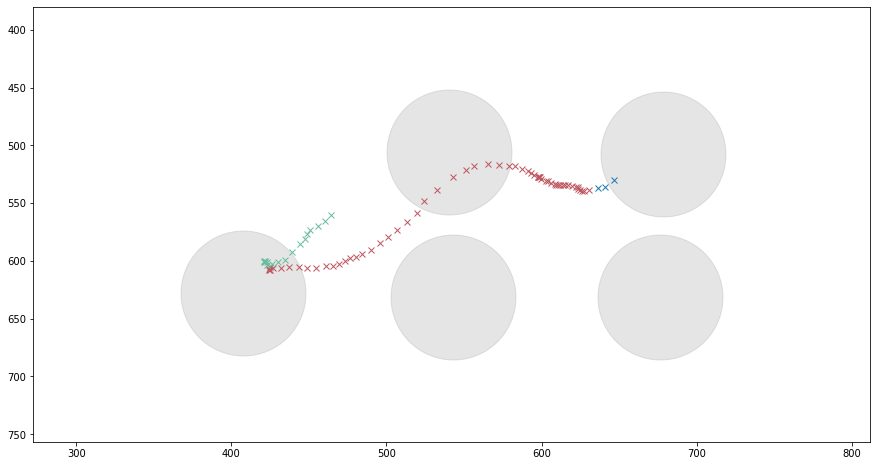

In [158]:

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()

    for i in range(len(filtered_split_trajectories_x_positions)):
        ax.plot(filtered_split_trajectories_x_positions[0][i], filtered_split_trajectories_y_positions[0][i], 'x',color = filtered_split_trajectories_frame_colors[0][i])

In [159]:

# covert colors back into numbers :
seq_types = []
for i in range(len(filtered_split_trajectories_frame_colors)):
    seq_type = []
    for string in filtered_split_trajectories_frame_colors[i]:
        index = colors.index(string)
        seq_type.append(index)
    seq_types += [seq_type]

# work out number of bins:
max_value = float('-inf')
for array in closest_indicies:
    for value in array:
        if value > max_value:
            max_value = value

# work out how often each type occurs at each point
standardized_seq_occurrences = [[] for i in range(max_value+1)]

for i_ in range(len(closest_indicies)):
    for i in range(len(closest_indicies[i_])):
        index = closest_indicies[i_][i]
        if not np.isnan(index):
            seq_type = seq_types[i_][i]
            standardized_seq_occurrences[index].append(seq_type)

# count each event for each bin:
seq_IDs = np.unique(unmasked_spikes_df.sequence_type_adjusted)[1::].astype(int)

count1 = []
count2 = []
count3 = []
count4 = []
count5 = []
count6 = []
       
for bin_ in standardized_seq_occurrences:
    count1 += [bin_.count(1)]
    count2 += [bin_.count(2)]
    count3 += [bin_.count(3)]
    count4 += [bin_.count(4)]
    count5 += [bin_.count(5)]
    count6 += [bin_.count(6)]
    
counts = [count1] + [count2] + [count3] + [count4] + [count5] + [count6]



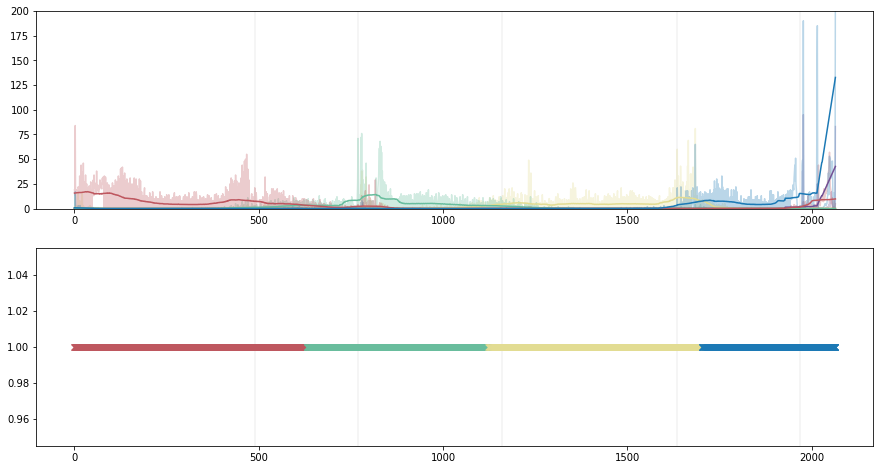

In [160]:

nrow = 2 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in av_curve_closestport_indicies[0]:
        ax.axvline(item,color = 'grey', alpha = 0.1)
    
    if ind == 0:

        ax.plot(count1,color = colors[1],alpha = 0.3)
        ax.plot(count2,color = colors[2],alpha = 0.3)
        ax.plot(count3,color = colors[3],alpha = 0.3)
        ax.plot(count4,color = colors[4],alpha = 0.3)
        ax.plot(count5,color = colors[5],alpha = 0.3)
        ax.plot(count6,color = colors[6],alpha = 0.3)



        smoothed_counts = []
        for i,count in enumerate(counts):
            ax.plot(convolve_movmean(count,100), color = colors[i+1] )
            smoothed_counts += [convolve_movmean(count,100)]
        ax.set_ylim(0,200)
        
    else:

        dominant = []
        for item in conactinate_nth_items(smoothed_counts[:]):
            dominant += [np.argmax(item)+1]

        for i in range(len(dominant)):
            plt.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])
        
        for i in range(len(dominant)):
            ax.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])
        

SaveFig('standard_space_nonwarp.png',save_path)


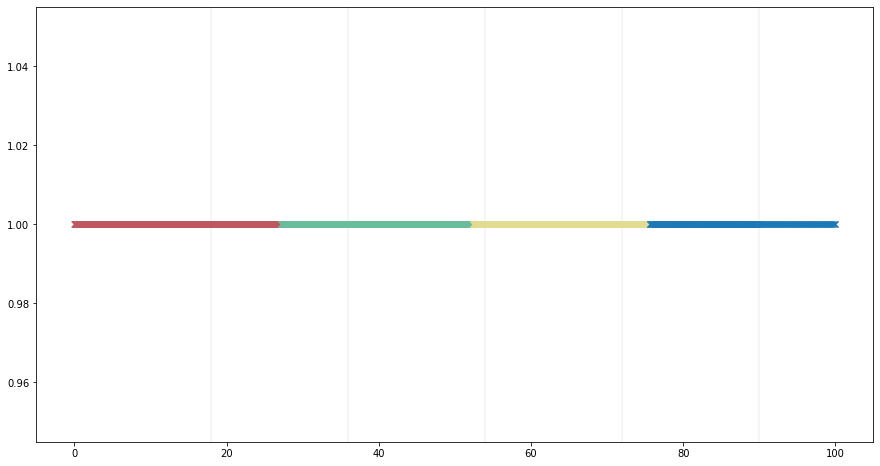

In [161]:
# warp this to standard space:

def map_y_to_x(y, indices, x_positions):
    x = np.zeros_like(y)
    for i, idx in enumerate(indices):
        x[idx] = x_positions[i]
    x = np.interp(np.arange(len(y)), indices, x_positions)
    x = np.interp(x, (x.min(), x.max()), (0, 100))
    return x

# Example y data and indices to map to x positions
warp_points = [0] + av_curve_closestport_indicies[0] + [len(dominant)-1]
x_positions = [0,18, 36, 54, 72, 90,100]
x_values = np.linspace(0,len(dominant)-1,len(dominant))
warped_x = map_y_to_x(x_values, warp_points, x_positions)

nrow = 1
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in x_positions[1:-1]:
        ax.axvline(item,color = 'grey', alpha = 0.1)
    
    for i in range(len(dominant)):
        plt.plot(warped_x[i], 1,'x', color = (np.array(colors)[dominant])[i])



SaveFig('standard_space_warped.png',save_path)



In [162]:
# save data:

count_df = pd.DataFrame({})
for i in range(len(counts)):
    count_df['seq_' + str(i) + '_counts'] = counts[i]
    
count_df.to_csv(save_path + '/binned_seq_occurance_df.csv')

import pickle

filename = 'warped_x'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(warped_x, fp)

filename = 'non_warped_standard_space_end_points'
with open(save_path + filename, 'wb') as fp:
    pickle.dump(av_curve_closestport_indicies[0], fp)

    
#save out count dominants:
# save out warped x 
# save out non warped end points 


#  Videos

plot spikes for each camera timeframe

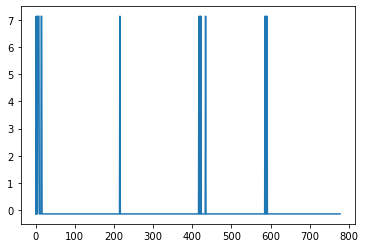

In [75]:
### plot spikes for each camera timeframe (spikes have to be binned into camera relevant 1/60 time bins to fit camera data )


from collections import Counter
import scipy.stats

def most_common_item(input_list):
    item_counts = Counter(input_list)
    most_common_items = item_counts.most_common()
    if len(most_common_items) > 1 and most_common_items[0][1] == most_common_items[1][1]:
        return -1
    return most_common_items[0][0]



example_neuron =64


# for example_neuron in np.unique(neuron_order[mask][background_remove_mask]).astype(int):

ind_ex = np.where(neuron_order[mask][background_remove_mask] == example_neuron)
spike_times = unmasked_spikes_df[mask][background_remove_mask].timestamp.values[ind_ex]
cam_adjusted_spike_times = spike_times + cam_start_time
colors_list = c_[ind_ex]


## bin such that each camera frame is a bin and count how mnay spikes occur in each one. then z score this

# Define the bin size (in this case, 0.2s)
bin_size = 1/60
binned_spikes, bins = np.histogram(spike_times, bins=np.arange(timeframe[0],timeframe[-1], bin_size))
z_scored_spikes = list(scipy.stats.zscore(binned_spikes, axis=0, ddof=0, nan_policy='propagate'))
plt.plot(z_scored_spikes)


## filter by z score
z_threshold = 0
xy_mask = [np.where(np.array(z_scored_spikes)>z_threshold)]


## work out spike bin color (ppseq group) assignment - if no one group is most common then spike will be plotted grey 
# soryt by assosicated spike bins 
binned_colors= []
count = 0
for item in binned_spikes:
    if item > 0:
        binned_colors += [list(colors_list[count:count+item])]
        count+=item
#work out most common color:
bin_colors = []
for item in binned_colors:
    if len(item) > 1:
        m_common = most_common_item(item)
        if m_common == -1:
            # no most common group
            bin_colors += ['grey']
        else:
            bin_colors += [m_common]

    else:
        bin_colors +=item

# the mask here is in camera ts indicies ie. its the camstart time for the timeframe * 60  to this value plus lenth of timeframe * 60
x_coords= back_head_centre['interped_x'][int(cam_start_time*60):int(cam_start_time*60)+(60*np.diff(timeframe)[0])].values[xy_mask][0]
y_coords= back_head_centre['interped_y'][int(cam_start_time*60):int(cam_start_time*60)+(60*np.diff(timeframe)[0])].values[xy_mask][0]


nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    # Custom the color, add shade and bandwidth
#     sns.kdeplot(x=x_coords, y=y_coords, cmap="Reds", shade=True, bw_adjust=.5, ax = ax)

    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 1)


    for i in range(len(x_coords)):
        ax.plot(x_coords[i],y_coords[i],'x',color = bin_colors[i], markersize = 10)

#     for i in range(int(events)):
#         ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)

    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()

    SaveFig(str(example_neuron) + '_.png',r"D:\test_data\\binned_nozscore_new\\")

In [77]:
from moviepy.editor import ImageSequenceClip

def add_spike_times_to_frame_(frame, x, y, color, prev_colour,prev_point,index,Plot_current):
    # Convert the frame to a PIL image
    img = Image.fromarray(frame)
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    # Draw the line on the image
    if Plot_current == True:
        #col = color[index]
        col = hex_format((200, 100,100))
        draw.text([x[index], y[index]], 'x', fill=col, font=ImageFont.truetype("arial.ttf", 40))
    # Draw the previous point on the image, if it exists
    if len(prev_point) >0:
        for index,point in enumerate(prev_point):
            color = prev_colour[index]
            draw.text([point[0],point[1]], 'x', fill=prev_colour[index], font=ImageFont.truetype("arial.ttf", 40))
    # Convert the image back to a numpy array
    return np.array(img)


def hex_format(col):
    return '#{:02X}{:02X}{:02X}'.format(col[0],col[1],col[2])

#### single neuron examples:
tot_frames = (end_ts[-1]/60 - start_ts[0]/60) * 60
frames_per_bin = bin_size/(1/60)

from moviepy.video.io.VideoFileClip import VideoFileClip

# Open the video file
clip = VideoFileClip(back_cam_avi_path)

# Extract clip
clip = clip.subclip(start_ts[0]/60, end_ts[-1]/60)

# Create a list to store the labeled frames
labeled_frames = []

# Create a variable to store the previous plotted point
prev_points = []
prev_colour = []
index_added = []
# Iterate through the frames of the clip
count = -1
for i, frame in enumerate(clip.iter_frames()):
    if i in xy_mask[0][0]:
        Plot_current = True
        count += 1
    else:
        Plot_current = False
    #try adding a line to the head
    if i < tot_frames-1:
        # Plot the point on the current frame using the previous plotted point
        labeled_frame = add_spike_times_to_frame_(frame,x_coords,y_coords,bin_colors,prev_colour,prev_points, count,Plot_current)
        if Plot_current == True:
            # Update the previous plotted point
            prev_points += [(x_coords[count],y_coords[count])]
            prev_colour += [hex_format((200, 100,100))]
            index_added += [i]
    # turn prvious points to grey after 60 frames
    for ind_,prev_c in enumerate(prev_colour):
        diff = i - index_added[ind_]
        if diff > 80:
            if diff >200:
                diff = 100
            else:
                # delay it a bit 
                diff = int(diff/2)
            # slow it down a bit but only updating every other
            if diff%2 == 0:
                new_color = (200 , 100 +diff, 100+ diff) 
                prev_colour[ind_] = hex_format(new_color)


    # Add the labeled frame to the list   
    labeled_frames.append(labeled_frame)

    
# Create a new clip with the labeled frames
labeled_clip = ImageSequenceClip(labeled_frames, fps=clip.fps)

# Save the labeled clip to a new video file
labeled_clip.write_videofile("D:\camera_test\\" + str(example_neuron) + "single_n_example.mp4")

KeyboardInterrupt: 

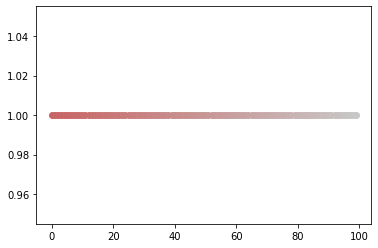

In [166]:
########## USEFUL: for calculating color change ######

for i in range(100):
    # Calculate the new color by reducing the amount of red in each iteration
    r = 200 
    g = 100 + i
    b = 100+ i
    # Create the color tuple
    colors = (r, g, b)
#     print(colors)
    plt.plot(i,1,'o', color = hex_format(colors))

Tracking video

In [86]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.editor import ImageSequenceClip


def add_tracking_line_to_frame(frame, x, y, color, prev_colour,prev_point):
    # Convert the frame to a PIL image
    img = Image.fromarray(frame)
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    # Draw the line on the image
    draw.text([x, y], 'o', fill=color, font=ImageFont.truetype("arial.ttf", 40))
    # Draw the previous point on the image, if it exists
    if len(prev_point) >0:
        if len(prev_point) >= 40:
            start_ = -20
        else:
            start_ = 0
        for index,point in enumerate(prev_point[start_::]):
            color = prev_colour[start_+index]
            draw.text([point[0],point[1]], 'o', fill=color, font=ImageFont.truetype("arial.ttf", 40))
    # Convert the image back to a numpy array
    return np.array(img)

## work out the start and end frames 
## work out the text an colour labels for each frame. 
tot_frames = (end_ts[-1]/60 - start_ts[0]/60) * 60
frames_per_bin = bin_size/(1/60)

frame_labels= []
for seq_label_ in np.array(colors)[np.array(max_index)+1][strt_:end_]:
    frame_labels += int(frames_per_bin) * [seq_label_]
    
# work out head centre position
x_coords = back_head_centre['interped_x'].values[int(start_ts[0]):int(end_ts[-1])]
y_coords = back_head_centre['interped_y'].values[int(start_ts[0]):int(end_ts[-1])]

# Open the video file
clip = VideoFileClip(back_cam_avi_path)

# Extract clip
clip = clip.subclip(start_ts[0]/60, end_ts[-1]/60)

# Create a list to store the labeled frames
labeled_frames = []


# Create a variable to store the previous plotted point
prev_points = []
prev_colour = []

# Iterate through the frames of the clip
for i, frame in enumerate(clip.iter_frames()):
    # Add the label to the frame
#     labeled_frame = add_label_to_frame(frame, frame_labels[i], frame_labels[i])
    #try adding a line to the head
    if i < tot_frames-1:
        # Plot the point on the current frame using the previous plotted point
        labeled_frame = add_tracking_line_to_frame(frame,x_coords[i],y_coords[i],frame_labels[i],prev_colour,prev_points)
        # Update the previous plotted point
        prev_points += [(x_coords[i],y_coords[i])]
        prev_colour += [frame_labels[i]]
    # Add the labeled frame to the list   
    labeled_frames.append(labeled_frame)
    

# Create a new clip with the labeled frames
labeled_clip = ImageSequenceClip(labeled_frames, fps=clip.fps)

# Save the labeled clip to a new video file
labeled_clip.write_videofile(save_path + 'seq_colour_overlay.mp4')


t:   0%|                                                                            | 0/1800 [00:00<?, ?it/s, now=None]

Moviepy - Building video Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\analysis_output\seq_colour_overlay.mp4.
Moviepy - Writing video Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\analysis_output\seq_colour_overlay.mp4



Moviepy - Done !
Moviepy - video ready Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\analysis_output\seq_colour_overlay.mp4


In [82]:
end_ts

248